In [1]:
import glob
import os
import librosa
import time
import numpy as np
import pandas as pd
from sklearn.feature_selection import SelectKBest, f_classif

In [2]:
emotions={
  '01':'neutral',
  '02':'calm',
  '03':'happy',
  '04':'sad',
  '05':'angry',
  '06':'fear',
  '07':'disgust',
  '08':'surprised'
}

observed_emotions = [
        'neutral',
        'calm',
        'happy',
        'sad',
        'angry',
        'fear',
        'disgust',
        'surprised']

In [3]:
# Feature extraction function (unchanged except result fix)
def extract_feature(file_name, mfcc, chroma, mel):
    X, sample_rate = librosa.load(os.path.join(file_name), res_type='kaiser_fast')
    result = np.array([])  # <-- Added this line, missing earlier
    if chroma:
        stft = np.abs(librosa.stft(X))
    result = np.array([])
    if mfcc:
         # MFCC base
        mfccs = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40)
        mfccs_mean = np.mean(mfccs.T, axis=0)

        # delta = librosa.feature.delta(mfccs)
        # delta_mean = np.mean(delta.T, axis=0)

        result = np.hstack((result, mfccs_mean))
    if chroma:
        chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
        result = np.hstack((result, chroma))
    if mel:
        mel = np.mean(librosa.feature.melspectrogram(y=X, sr=sample_rate).T, axis=0)
        result = np.hstack((result, mel))
    return result

In [4]:
# Loading only RAVDESS dataset
def load_data(test_size=0.2): 
    x, y = [], []

    # Searching in both songs and speech folders
    paths = [
        "audio/songs/Actor_*/**/*.wav",
        "audio/speech/Actor_*/**/*.wav"
    ]

    for path in paths:
        for file in glob.glob(path, recursive=True):
            file_name = os.path.basename(file)
            emotion_code = file_name.split("-")[2]
            emotion = emotions.get(emotion_code)
            if emotion not in observed_emotions:
                continue
            feature = extract_feature(file,mfcc=True, chroma=True, mel=True)
            x.append(feature)
            y.append(emotion)
    
    return {"X": x, "y": y}

In [5]:
# Timing and loading
start_time = time.time()
Trial_dict = load_data(test_size=0.2)
print("--- Data loaded. Loading time: %s seconds ---" % (time.time() - start_time))


--- Data loaded. Loading time: 128.097309589386 seconds ---


In [6]:
# Create dataframes
X = pd.DataFrame(Trial_dict["X"])
y = pd.DataFrame(Trial_dict["y"])

In [7]:
# Combine and shuffle
data = pd.concat([X, y], axis=1)
data = data.reindex(np.random.permutation(data.index))

In [8]:
# Save to CSV
data.to_csv("RAVDESS_MFCC_Observed.csv")

In [9]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sn

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [10]:
# Load the dataset
start_time = time.time()
data = pd.read_csv('RAVDESS_MFCC_Observed.csv')
print("Data loaded in {:.2f} seconds".format(time.time() - start_time))

Data loaded in 0.09 seconds


In [11]:
# Drop the extra index column if present
if 'Unnamed: 0' in data.columns:
    data = data.drop('Unnamed: 0', axis=1)

In [12]:
data.head()

,0,1,2,3,4,5,6,7,8,9,...,171,172,173,174,175,176,177,178,179,0.1
0,-529.457458,35.983887,-34.191166,5.589591,-21.283846,-9.243513,-8.900265,-18.199436,-10.441176,-1.438399,...,0.000093,0.000077,0.000054,0.000025,0.000008,0.000003,5.254037e-07,4.553223e-08,1.362153e-09,neutral
1,-413.804504,43.762199,-17.636662,-5.817533,-7.452943,-4.657783,-5.412855,-2.747631,-12.647045,6.043597,...,0.009007,0.010040,0.007665,0.004420,0.001749,0.000548,8.073057e-05,9.394029e-06,3.781470e-07,angry
2,-656.609497,45.468124,-6.988225,6.338575,-6.843240,-2.749292,-11.023989,-9.711976,-6.052428,-1.428535,...,0.000052,0.000088,0.000034,0.000035,0.000013,0.000003,5.581646e-07,3.037144e-08,1.424306e-09,sad
3,-480.859344,40.344318,-22.254679,8.064910,-2.196128,-7.388104,-4.482468,-1.050172,-9.112947,6.507394,...,0.000399,0.000373,0.000370,0.000343,0.000096,0.000018,3.361362e-06,3.108785e-07,9.917381e-09,happy
4,-522.562195,33.351440,-13.026981,9.276735,-9.381211,-11.071786,-17.914160,-7.903302,-11.241575,0.989510,...,0.005397,0.007083,0.005377,0.002390,0.000912,0.000262,3.308545e-05,2.974593e-06,8.228523e-08,happy


In [13]:
print(data.columns)


Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
       ...
       '171', '172', '173', '174', '175', '176', '177', '178', '179', '0.1'],
      dtype='object', length=181)


In [14]:
# Rename the last column to 'emotion'
data.rename(columns={data.columns[-1]: 'emotion'}, inplace=True)

# Now proceed normally
X = data.drop('emotion', axis=1).values
y = data['emotion'].values


In [15]:
print(data.head())
print(data.columns.tolist())


            0          1          2         3          4          5  \
0 -529.457458  35.983887 -34.191166  5.589591 -21.283846  -9.243513   
1 -413.804504  43.762199 -17.636662 -5.817533  -7.452943  -4.657783   
2 -656.609497  45.468124  -6.988225  6.338575  -6.843240  -2.749292   
3 -480.859344  40.344318 -22.254679  8.064910  -2.196128  -7.388104   
4 -522.562195  33.351440 -13.026981  9.276735  -9.381211 -11.071786   

           6          7          8         9  ...       171       172  \
0  -8.900265 -18.199436 -10.441176 -1.438399  ...  0.000093  0.000077   
1  -5.412855  -2.747631 -12.647045  6.043597  ...  0.009007  0.010040   
2 -11.023989  -9.711976  -6.052428 -1.428535  ...  0.000052  0.000088   
3  -4.482468  -1.050172  -9.112947  6.507394  ...  0.000399  0.000373   
4 -17.914160  -7.903302 -11.241575  0.989510  ...  0.005397  0.007083   

        173       174       175       176           177           178  \
0  0.000054  0.000025  0.000008  0.000003  5.254037e-07  4.55

In [16]:
print("X shape:", X.shape)
print("Unique labels:", np.unique(y))

X shape: (2452, 180)
Unique labels: ['angry' 'calm' 'disgust' 'fear' 'happy' 'neutral' 'sad' 'surprised']


In [17]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [18]:
# -----------------------------
# 1️⃣ Baseline SVM (without scaling)
# -----------------------------
print("\nTraining SVM without scaling...")
svm_unscaled = SVC(kernel='linear')
start = time.time()
svm_unscaled.fit(X_train, y_train)
print("Trained in {:.2f} seconds".format(time.time() - start))


Training SVM without scaling...
Trained in 30.64 seconds



Classification Report (Unscaled):
               precision    recall  f1-score   support

       angry       0.68      0.72      0.70        64
        calm       0.58      0.62      0.60        73
     disgust       0.56      0.46      0.51        50
        fear       0.47      0.59      0.52        70
       happy       0.67      0.56      0.61        73
     neutral       0.52      0.50      0.51        34
         sad       0.61      0.56      0.58        86
   surprised       0.44      0.46      0.45        41

    accuracy                           0.57       491
   macro avg       0.56      0.56      0.56       491
weighted avg       0.58      0.57      0.57       491

Accuracy (Unscaled): 57.03%


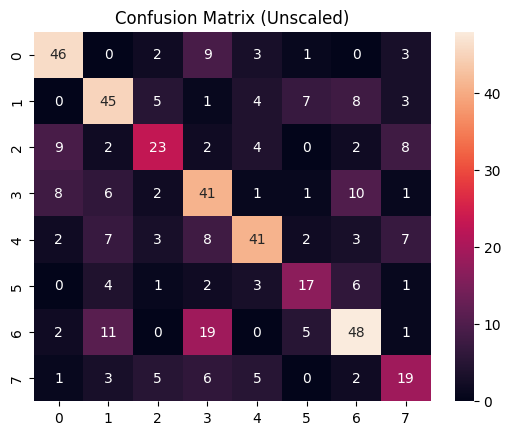

In [19]:
# Predict & evaluate
y_pred_unscaled = svm_unscaled.predict(X_test)
print("\nClassification Report (Unscaled):\n", classification_report(y_test, y_pred_unscaled))
print("Accuracy (Unscaled): {:.2f}%".format(accuracy_score(y_test, y_pred_unscaled) * 100))

# Confusion matrix
cm_unscaled = confusion_matrix(y_test, y_pred_unscaled)
sn.heatmap(pd.DataFrame(cm_unscaled), annot=True, fmt='d')
plt.title("Confusion Matrix (Unscaled)")
plt.show()

In [20]:
# -----------------------------
# 2️⃣ SVM with Standard Scaling (Pipeline)
# -----------------------------
print("\nTraining SVM with scaling (Pipeline)...")
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='linear'))
])
pipeline.fit(X_train, y_train)


Training SVM with scaling (Pipeline)...


Pipeline(steps=[('scaler', StandardScaler()), ('svm', SVC(kernel='linear'))])

In [21]:
# Predict & evaluate
y_pred_scaled = pipeline.predict(X_test)
print("\nClassification Report (Scaled):\n", classification_report(y_test, y_pred_scaled))
print("Accuracy (Scaled): {:.2f}%".format(accuracy_score(y_test, y_pred_scaled) * 100))




Classification Report (Scaled):
               precision    recall  f1-score   support

       angry       0.60      0.77      0.68        64
        calm       0.62      0.62      0.62        73
     disgust       0.59      0.52      0.55        50
        fear       0.42      0.47      0.45        70
       happy       0.63      0.55      0.59        73
     neutral       0.53      0.53      0.53        34
         sad       0.57      0.53      0.55        86
   surprised       0.49      0.46      0.47        41

    accuracy                           0.56       491
   macro avg       0.56      0.56      0.56       491
weighted avg       0.56      0.56      0.56       491

Accuracy (Scaled): 56.21%


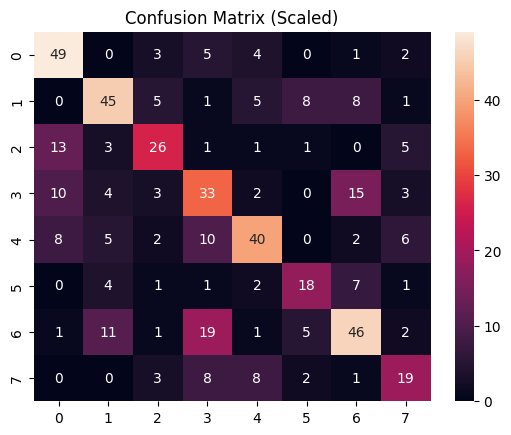

In [22]:
# Confusion matrix
cm_scaled = confusion_matrix(y_test, y_pred_scaled)
sn.heatmap(pd.DataFrame(cm_scaled), annot=True, fmt='d')
plt.title("Confusion Matrix (Scaled)")
plt.show()

In [23]:
# -----------------------------
# 3️⃣ Cross-validation
# -----------------------------
print("\nCross-validation accuracy scores (5-fold):")
cv_scores = cross_val_score(pipeline, X, y, cv=5)
print(cv_scores)
print("Mean CV accuracy: {:.2f}%".format(np.mean(cv_scores) * 100))


Cross-validation accuracy scores (5-fold):
[0.62118126 0.63747454 0.58367347 0.58979592 0.57142857]
Mean CV accuracy: 60.07%


In [24]:
train_acc = pipeline.score(X_train, y_train) * 100
test_acc = pipeline.score(X_test, y_test) * 100
print("Train Accuracy (Scaled): {:.2f}%".format(train_acc))
print("Test Accuracy (Scaled): {:.2f}%".format(test_acc))

Train Accuracy (Scaled): 82.51%
Test Accuracy (Scaled): 56.21%


In [25]:
from sklearn.model_selection import GridSearchCV

pipeline = Pipeline([
    # ('select', SelectKBest(score_func=f_classif, k=50)),
    ('scaler', StandardScaler()),
    ('svm', SVC())
])

param_grid = {
    'svm__kernel': ['linear', 'rbf'],
    'svm__C': [0.1, 1, 10],
    'svm__gamma': ['scale', 'auto']
}

grid = GridSearchCV(pipeline, param_grid, cv=5, verbose=1, n_jobs=-1)
grid.fit(X_train, y_train)

print("✅ Best Parameters:", grid.best_params_)
print("✅ Best Cross-Validation Accuracy: {:.2f}%".format(grid.best_score_ * 100))


Fitting 5 folds for each of 12 candidates, totalling 60 fits
✅ Best Parameters: {'svm__C': 10, 'svm__gamma': 'scale', 'svm__kernel': 'rbf'}
✅ Best Cross-Validation Accuracy: 70.58%


In [26]:
y_pred = grid.predict(X_test)

print(classification_report(y_test, y_pred))
print("Test Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred) * 100))


              precision    recall  f1-score   support

       angry       0.70      0.86      0.77        64
        calm       0.71      0.84      0.77        73
     disgust       0.76      0.64      0.70        50
        fear       0.65      0.73      0.68        70
       happy       0.70      0.55      0.62        73
     neutral       0.61      0.59      0.60        34
         sad       0.74      0.63      0.68        86
   surprised       0.67      0.68      0.67        41

    accuracy                           0.69       491
   macro avg       0.69      0.69      0.69       491
weighted avg       0.70      0.69      0.69       491

Test Accuracy: 69.45%
